In [1]:
%matplotlib nbagg
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

mypath = 'X:\\RIXS\\Ruiz_e18603\\'
base = 'Cu'
scans = np.arange(102,112+1)

In [2]:
os.chdir(mypath)

def gaussian_norm(x,mu,sig,amp):
    norm = (1./(np.sqrt(2*np.pi)*sig))
    return amp*norm*np.exp(-((x-mu)**2)/(2*sig**2))

def fitpeak(data):
    center = np.argmax(data)
    xdata = np.arange(len(data))
    popt,pcov = curve_fit(gaussian_norm, xdata, data, p0=[center,10.,np.max(data)])
    mu = popt[0]
    sigma = popt[1]
    return mu,sigma

def getdata(scannumber):
    global mypath
    global base
    
    if scannumber < 10:
        filename = mypath+'RIXS\\'+base+"_"+"000"+str(scannumber)
    elif scannumber < 100:
        filename = mypath+'RIXS\\'+base+"_"+"00"+str(scannumber)
    elif scannumber < 1000:    
        filename = mypath+'RIXS\\'+base+"_"+"0"+str(scannumber)
    else:    
        filename = mypath+base+"_"+str(scannumber)

    f1 = h5py.File(filename+"_d1.h5", 'r')
    f2 = h5py.File(filename+"_d2.h5", 'r')
    f3 = h5py.File(filename+"_d3.h5", 'r')

    ccd1 = f1['entry']['analysis']['spectrum'][()]
    ccd2 = f2['entry']['analysis']['spectrum'][()]
    ccd3 = f3['entry']['analysis']['spectrum'][()]
    
    mu1,sig1 = fitpeak(ccd1)
    mu2,sig2 = fitpeak(ccd2)
    mu3,sig3 = fitpeak(ccd3)

    energy = round(np.mean(f3['entry']['instrument']['NDAttributes']['PhotonEnergy'][()]),2)
    
    return energy,[mu1,sig1,mu2,sig2,mu3,sig3]
    
    

<IPython.core.display.Javascript object>


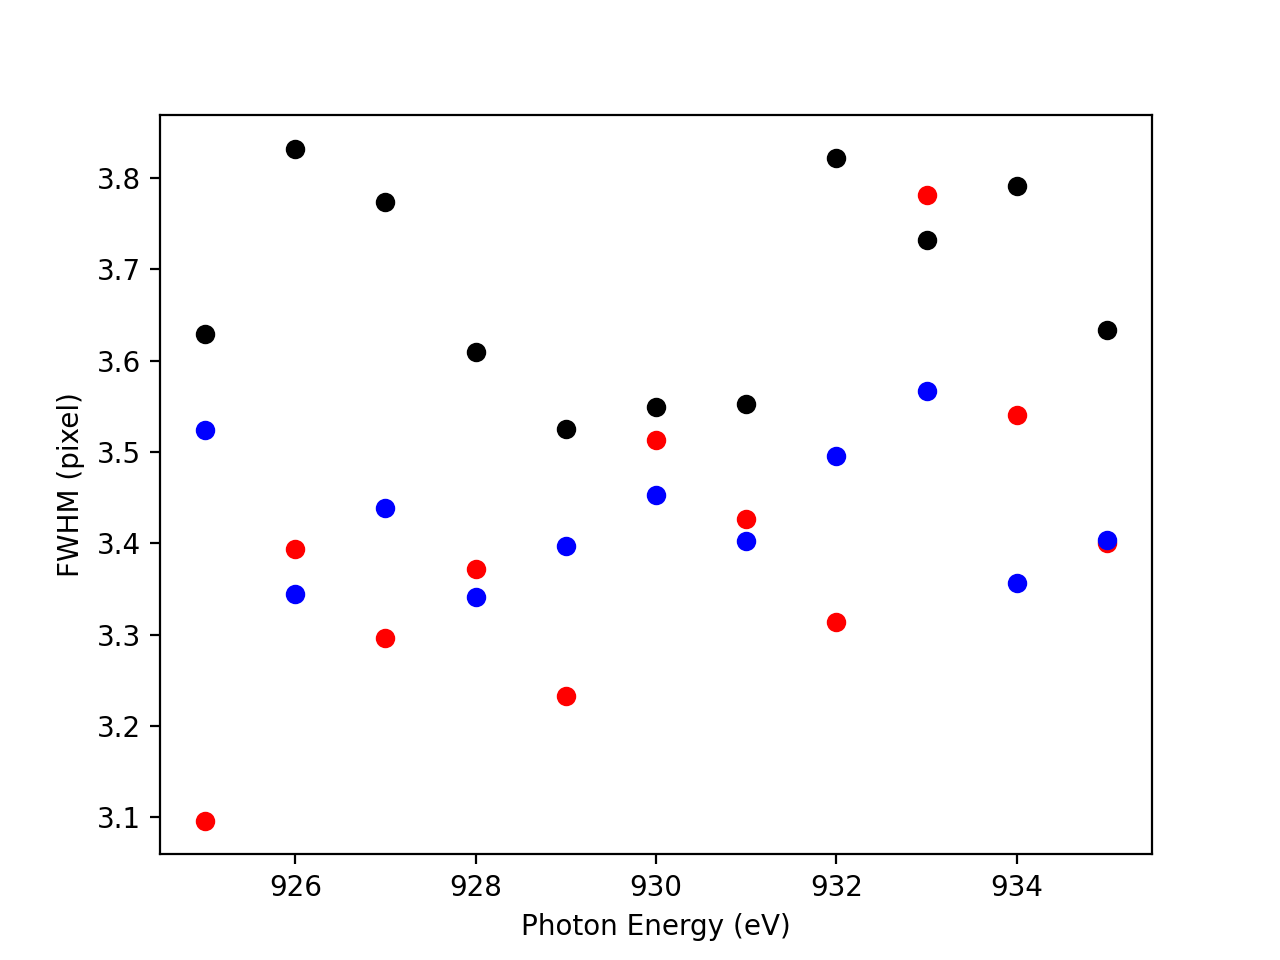

In [3]:
fwhm1 = []
fwhm2 = []
fwhm3 = []
center1 = []
center2 = []
center3 = []
energy = []

for i,s in enumerate(scans):
    en,[mu1,sigma1,mu2,sigma2,mu3,sigma3]= getdata(s)
    energy.append(en)
    
    fwhm1.append(sigma1*2.355)
    center1.append(mu1)
    plt.plot(en,sigma1*2.355/4,'o',color = "black")
    fwhm2.append(sigma2*2.355)
    center2.append(mu2)
    plt.plot(en,sigma2*2.355/4,'o',color = "red")
    fwhm3.append(sigma3*2.355)
    center3.append(mu3)
    plt.plot(en,sigma3*2.355/4,'o',color = "blue")
    
plt.xlabel('Photon Energy (eV)')
plt.ylabel('FWHM (pixel)')

[myslope1,myinter1] = np.polyfit(energy,center1,1)
[myslope2,myinter2] = np.polyfit(energy,center2,1)
[myslope3,myinter3] = np.polyfit(energy,center3,1)
energypersubpixel = 3/(myslope1+myslope2+myslope3)

In [4]:
print('Slope = '+str(energypersubpixel*1000)+' meV/subpixel')
print('Energy resolution = '+str(np.mean(fwhm1+fwhm2+fwhm3)*energypersubpixel*1000)+' meV')

Slope = 8.127961731376095 meV/subpixel
Energy resolution = 113.82953641807242 meV


<IPython.core.display.Javascript object>


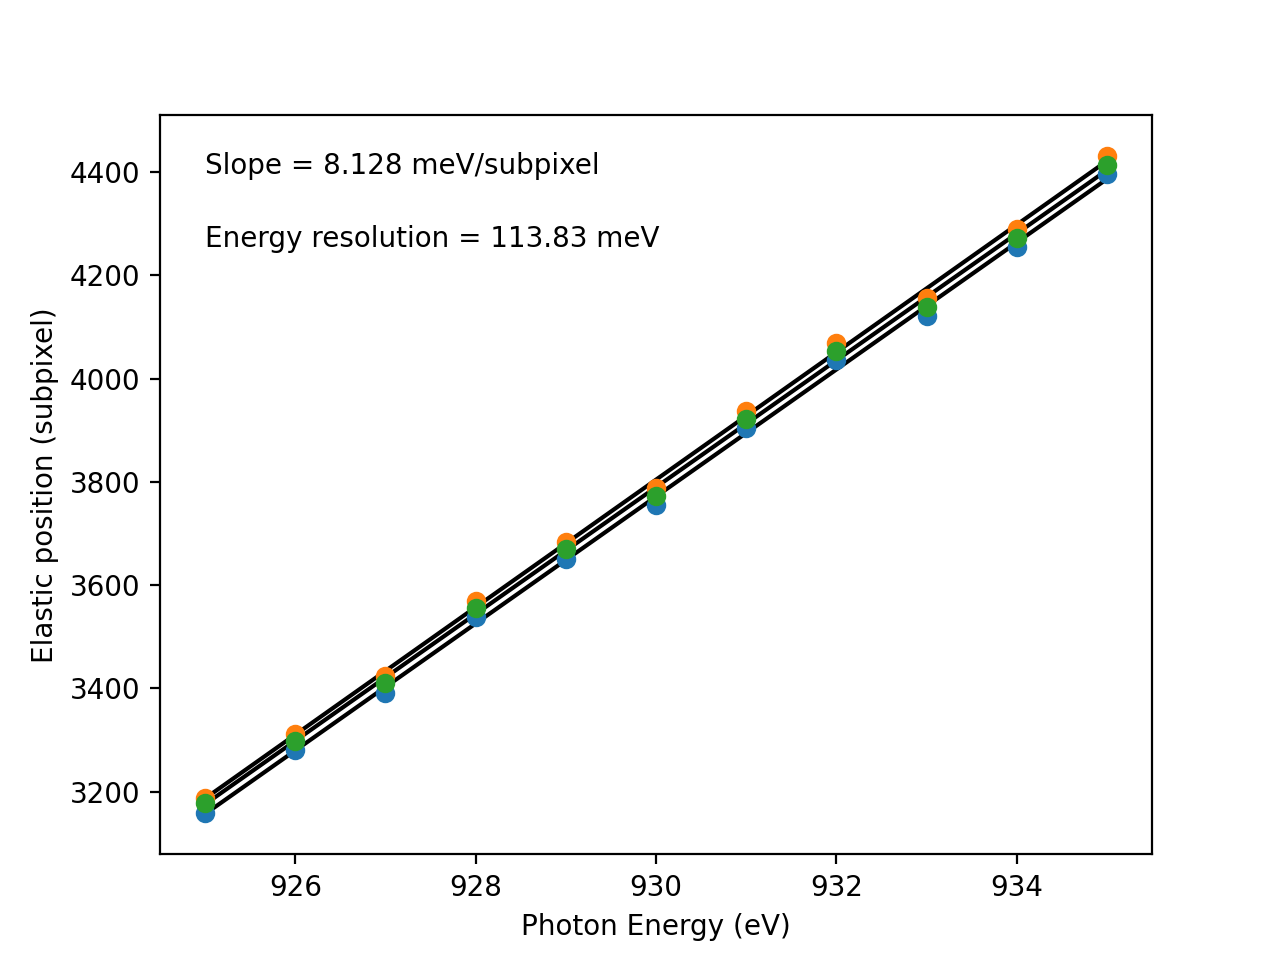

In [5]:
xplot = np.linspace(energy[0],energy[-1],100)
plt.figure()
plt.errorbar(energy,center1,yerr=fwhm1,xerr=None,linewidth=0,marker = "o")
plt.errorbar(energy,center2,yerr=fwhm2,xerr=None,linewidth=0,marker = "o")
plt.errorbar(energy,center3,yerr=fwhm3,xerr=None,linewidth=0,marker = "o")
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Elastic position (subpixel)')
plt.plot(xplot,myslope1*xplot+myinter1, color = 'black')
plt.plot(xplot,myslope2*xplot+myinter2, color = 'black')
plt.plot(xplot,myslope3*xplot+myinter3, color = 'black')
plt.annotate('Slope = '+str(round(energypersubpixel*1000,3))+' meV/subpixel',xy = (energy[0],center1[-1]))
plt.annotate('Energy resolution = '+str(round(np.mean(fwhm1+fwhm2+fwhm3)*energypersubpixel*1000,3))+' meV',xy = (energy[0],center1[-2]))
plt.savefig('resolution.png',dpi=600)